In [5]:
import pandas as pd
data_with_correct = pd.read_csv("data/final_data/all-word-feature-20240723-103-with-correct.csv")
data_without_correct = pd.read_csv("data/final_data/all-word-feature-20240723-103.csv")

# 简单的base模型

In [13]:
import re
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc

class PredictAndEvalute:
    def __init__(self, df, use_word):
        self.df = df
        self.df['word'] = self.df['word'].apply(self.clean_text)
        self.X = self.df.drop(['word_understand','word', 'user'], axis=1)  # Features
        self.y = self.df['word_understand']  # Target variable
        self.use_word = use_word

    def clean_text(self, text):
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        text = text.lower()  # Convert to lowercase
        return text

    def text_to_vector(self):
        # Initialize CountVectorizer
        vectorizer = CountVectorizer()
        # Vectorize text column
        X_word = vectorizer.fit_transform(self.df['word'])
        # Convert sparse matrix to dense matrix if needed
        X_word = X_word.toarray()
        # Concatenate vectorized features with original features
        self.X = np.concatenate((X_word, self.df.drop(['word', 'word_understand'], axis=1).values), axis=1)

    def predict(self, output_file=None):
        if self.use_word:
            self.text_to_vector()

        # Split dataset into train and test
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3, random_state=42)
        model = LogisticRegression()
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        print(classification_report(y_test, y_pred))
        auc_score = roc_auc_score(y_test, y_pred_proba)
        print(f"AUC: {auc_score}")
        results_df = X_test
        results_df['y_pred'] = y_pred.tolist()
        results_df['y_label'] = y_test.tolist()
        
        if output_file != None:
            # Save results to CSV
            results_df.to_csv(output_file, index=False)
            print(f"Predictions saved to {output_file}")

In [17]:
allDataModel = PredictAndEvalute(data_with_correct, False)
allDataModel.predict()

              precision    recall  f1-score   support

           0       0.42      0.09      0.15       274
           1       0.98      1.00      0.99     12068

    accuracy                           0.98     12342
   macro avg       0.70      0.55      0.57     12342
weighted avg       0.97      0.98      0.97     12342

AUC: 0.8854043933525109


/Users/bytedance/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [16]:
allDataModel = PredictAndEvalute(data_without_correct, False)
allDataModel.predict()

              precision    recall  f1-score   support

           0       0.52      0.09      0.16       274
           1       0.98      1.00      0.99     12068

    accuracy                           0.98     12342
   macro avg       0.75      0.55      0.57     12342
weighted avg       0.97      0.98      0.97     12342

AUC: 0.8544531112019723


/Users/bytedance/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [6]:
# 拆分跳读与非跳读数据

In [7]:
# 按照 exp_id 进行分组，并对其他列进行聚合操作
aggregated_df = df.groupby('exp_id').agg({
    'reading_times': 'sum',         # 其他数值型特征可以选择求和、平均值等操作
    'number_of_fixations': 'sum',
    'fixation_duration': 'sum',
    'fixation_duration_div_syllable': 'sum',
    'fixation_duration_div_length': 'sum',
    'fixation_duration_diff': 'sum',
    'number_of_fixations_diff': 'sum',
    'reading_times_diff': 'sum'
}).reset_index()

# 查看聚合后的数据
print(aggregated_df)

    exp_id  reading_times  number_of_fixations  fixation_duration  \
0      585            211                  300             109705   
1      590            259                  340             129146   
2      597            246                  314             124564   
3      598            377                  507             208897   
4      630            427                  594             235581   
5      641            336                  442             161023   
6      902            181                  219              71207   
7      903            320                  426             144789   
8      904            273                  335             111995   
9      941            219                  283              96431   
10     962            196                  239              84500   
11     965            356                  521             202019   
12     970            408                  560             220356   
13     972            196         

In [8]:
# 按照 fixation_duration 列降序排序，并选择只显示 exp_id 列
sorted_exp_ids = aggregated_df.sort_values(by='fixation_duration', ascending=False)['exp_id']
lens = int(len(sorted_exp_ids) * 0.8)
not_skip_ids = sorted_exp_ids[:lens]
skip_ids = sorted_exp_ids[lens:len(sorted_exp_ids)]
# 打印排序后的 exp_id
print(len(not_skip_ids))
print(not_skip_ids)

26
20    1073
4      630
21    1074
12     970
19    1072
3      598
11     965
22    1090
18    1071
23    1091
5      641
24    1129
14    1011
27    1144
7      903
15    1014
1      590
2      597
8      904
31    1151
0      585
13     972
29    1146
28    1145
30    1149
9      941
Name: exp_id, dtype: int64


In [9]:
not_skip_data = df[df['exp_id'].isin(not_skip_ids)]
not_skip_data

,exp_id,word,word_understand,reading_times,number_of_fixations,fixation_duration,fixation_duration_div_syllable,fixation_duration_div_length,fixation_duration_diff,number_of_fixations_diff,reading_times_diff
0,585,a,1,0,0,0,0.0,0.0,0,0,0
1,585,judge,1,1,3,927,927.0,185.4,927,3,1
2,585,in,1,1,1,245,245.0,122.5,-682,-2,0
3,585,the,1,0,0,0,0.0,0.0,-245,-1,-1
4,585,us,1,1,1,321,321.0,160.5,321,1,1
...,...,...,...,...,...,...,...,...,...,...,...
11859,1151,be,1,0,0,0,0.0,0.0,0,0,0
11860,1151,specified,1,0,0,0,0.0,0.0,0,0,0
11861,1151,in,1,0,0,0,0.0,0.0,0,0,0
11862,1151,computational,1,0,0,0,0.0,0.0,0,0,0


In [10]:
skip_data = df[df['exp_id'].isin(skip_ids)]
skip_data

,exp_id,word,word_understand,reading_times,number_of_fixations,fixation_duration,fixation_duration_div_syllable,fixation_duration_div_length,fixation_duration_diff,number_of_fixations_diff,reading_times_diff
2302,902,senior,1,0,0,0,0.000000,0.000000,0,0,0
2303,902,iranian,1,1,1,215,71.666667,30.714286,215,1,1
2304,902,figures,1,0,0,0,0.000000,0.000000,-215,-1,-1
2305,902,have,1,1,2,818,818.000000,204.500000,818,2,1
2306,902,expressed,1,1,1,292,146.000000,32.444444,-526,-1,0
...,...,...,...,...,...,...,...,...,...,...,...
12167,1156,enough,1,0,0,0,0.000000,0.000000,0,0,0
12168,1156,to,1,0,0,0,0.000000,0.000000,0,0,0
12169,1156,deflect,0,0,0,0,0.000000,0.000000,0,0,0
12170,1156,its,1,0,0,0,0.000000,0.000000,0,0,0


In [11]:
sequenceDataModel = PredictAndEvalute(not_skip_data, False)
sequenceDataModel.predict()

/tmp/ipykernel_112942/1488859566.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['word'] = self.df['word'].apply(self.clean_text)


              precision    recall  f1-score   support

           0       0.53      0.17      0.26        52
           1       0.99      1.00      0.99      2924

    accuracy                           0.98      2976
   macro avg       0.76      0.59      0.63      2976
weighted avg       0.98      0.98      0.98      2976

AUC: 0.8667262969588551


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
skipDataModel = PredictAndEvalute(skip_data, False)
skipDataModel.predict()

/tmp/ipykernel_112942/1488859566.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['word'] = self.df['word'].apply(self.clean_text)


              precision    recall  f1-score   support

           0       0.67      0.08      0.15        24
           1       0.97      1.00      0.98       653

    accuracy                           0.97       677
   macro avg       0.82      0.54      0.57       677
weighted avg       0.96      0.97      0.95       677

AUC: 0.8219754977029097


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# 数据分析
# 目标：分析跳读性能低的原因

In [30]:
# 之前存储的跳读的预测的数据
import pandas as pd
skip_data = pd.read_csv('skip_data_predict.csv')
sequnece_data = pd.read_csv('not_skip_predicted.csv')
recall_data = skip_data[(skip_data['predicted_label']==1)&(skip_data['true_label']==0)]
pd.set_option('display.max_rows', 15)
recall_data


,exp_id,reading_times,number_of_fixations,fixation_duration,fixation_duration_div_syllable,fixation_duration_div_length,fixation_duration_diff,number_of_fixations_diff,reading_times_diff,word,predicted_label,true_label
10,902,2,3,821,410.50,117.285714,821,3,2,custody,1,0
36,902,0,0,0,0.00,0.000000,0,0,0,probe,1,0
49,902,1,2,949,237.25,94.900000,725,1,0,repetition,1,0
63,902,1,1,501,501.00,83.500000,501,1,1,jailed,1,0
159,902,0,0,0,0.00,0.000000,-991,-3,-3,assaulted,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2192,1156,1,2,791,395.50,87.888889,191,1,0,scuffling,1,0
2203,1156,2,2,1073,1073.00,214.600000,499,1,1,probe,1,0
2206,1156,1,2,642,214.00,80.250000,642,2,1,asteroid,1,0
2223,1156,3,4,1691,845.50,241.571429,1424,3,2,sizable,1,0


In [36]:
import matplotlib.pyplot as plt
def plot_hist(barData):
    plt.hist(barData, bins=10, edgecolor='black', density=True)  # density=True makes the y-axis show proportions
    plt.xlabel('Fixation duration')
    plt.ylabel('Proportion')
    plt.title('Distribution of Predict')
    plt.grid(True)
    plt.show()

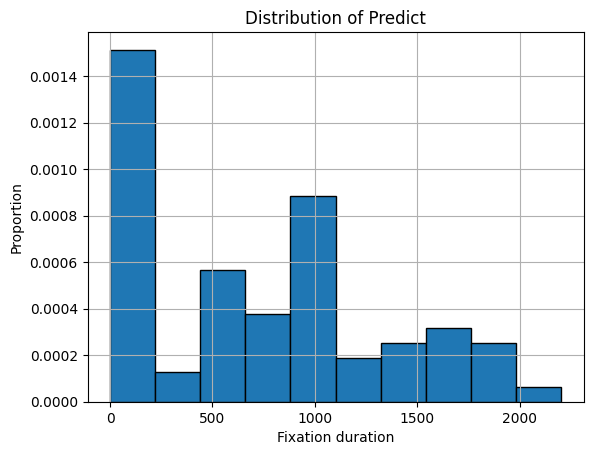

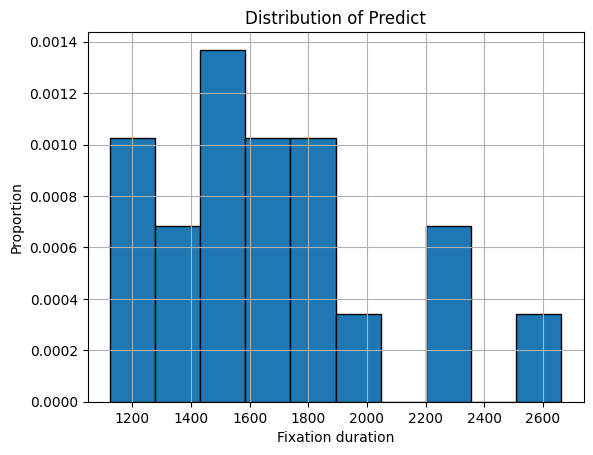

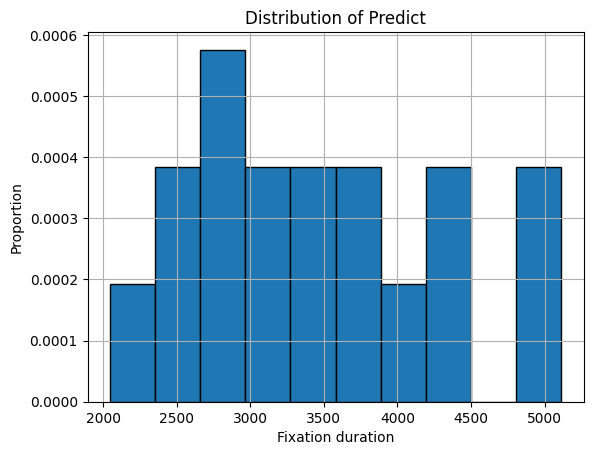

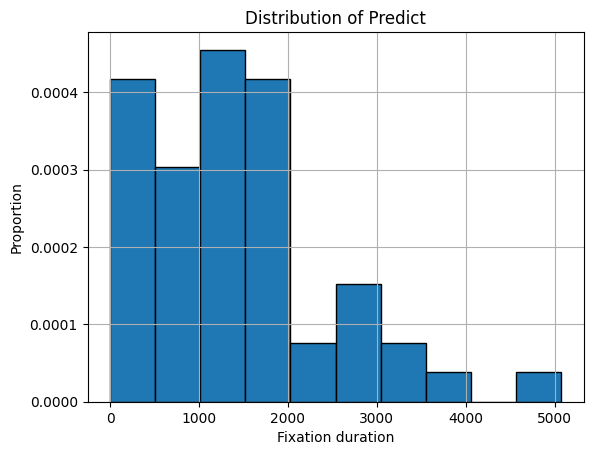

In [38]:
# 查看跳读数据中真实不懂的label的特征分布，和预测为不懂的分布差异
skipNotUnderStandTrueLabelData = skip_data[skip_data['true_label']==0]['fixation_duration']
skipNotUnderStandPredictLabelData = skip_data[skip_data['predicted_label']==0]['fixation_duration']
sequenceNotUnderStandTrueLabelData = sequnece_data[sequnece_data['y_pred']==0]['fixation_duration']
sequenceNotUnderStandPredictLabelData = sequnece_data[sequnece_data['y_label']==0]['fixation_duration']
plot_hist(skipNotUnderStandTrueLabelData)
plot_hist(skipNotUnderStandPredictLabelData)
plot_hist(sequenceNotUnderStandTrueLabelData)
plot_hist(sequenceNotUnderStandPredictLabelData)



In [54]:
# 看一下预测错了的predict为0的占比
allWrongRecallData = skip_data[(skip_data['predicted_label']==1)&(skip_data['true_label']==0)]
allWrongRecallDataWithoutFixation = allWrongRecallData[allWrongRecallData['fixation_duration']==0]
len(allWrongRecallDataWithoutFixation) / len(allWrongRecallData)

0.3333333333333333

In [56]:
# 顺序阅读数据呢？
allWrongRecallSequenceData = sequnece_data[(sequnece_data['y_pred']==1)&(sequnece_data['y_label']==0)]
allWrongRecallSequenceDataWithoutFixation = allWrongRecallSequenceData[allWrongRecallSequenceData['fixation_duration']==0]
len(allWrongRecallSequenceDataWithoutFixation) / len(allWrongRecallSequenceData)

0.11627906976744186

In [57]:
# 差距还是比较大的
# 说明在